# Lab 5

### Author: Pawel Jelonek

### Date: 01.03.2022

In [5]:
import nltk

from sklearn.model_selection import train_test_split
from tensorflow.python.keras.callbacks import EarlyStopping

nltk.download('punkt') # tokenization
nltk.download('stopwords') # stopwords
nltk.download('wordnet') # lemmatization
nltk.download('omw-1.4') # lemmatization
nltk.download('averaged_perceptron_tagger') # tagging
nltk.download('tagsets') # tagging
nltk.download('brown') # word2vec

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pawst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pawst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pawst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pawst\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pawst\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\pawst\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_d

## 1. Proszę zapoznać się (ostatecznie) z modelem analizy danych tekstowych.

#### Dziedzina  techniki  zajmująca  się  przetwarzaniem komputerowym nieustrukturyzowanych danych w postaci dokumentów tekstowych  i wyciągania  z nich  informacji wysokiej jakości nazywa się  eksploracją tekstu

![image.png](attachment:image.png)

#### W  eksploracyjnej  analizie  tekstu  dostępne  są  dwie metody przetwarzania tekstu: płytkie i głębokie. Pierwsza metoda  dotycząca  płytkiej  analizy  tekstu  (ang.  shallow text  processing  –  STP),  określa  grupę  działań polegających  na  rozpoznawaniu  struktur  tekstów nierekurencyjnych  lub  o  ograniczonym  poziomie rekurencji, które mogą być rozpoznane z dużym stopniem pewności.  Struktury wymagające  złożonej analizy  wielu możliwych  rozwiązań  są  pomijane  lub  analizowane częściowo.  Analiza  skierowana  jest  głównie  na rozpoznawanie  nazw  własnych,  wyrażeń rzeczownikowych,  grup  czasownikowych  bez rozpoznawania  ich  wewnętrznej  struktury  i  funkcji  w zdaniu.



## 2. Przeprowadzić tzw. analizę nastawienia (sentiment analysis) z danych tekstowych.

Dataset: **[Steam Game Review Dataset](https://www.kaggle.com/arashnic/game-review-dataset)**

In [6]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Load & Prepare data

In [7]:
df_data = pd.read_csv("./src/Steam reviews/train_gr/train.csv", error_bad_lines=False)
df_data.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [8]:
df_data.columns

Index(['review_id', 'title', 'year', 'user_review', 'user_suggestion'], dtype='object')

In [9]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB


Check if dataset contains n/a

In [10]:
print(df_data.isna().sum())
df_data.dropna(inplace=True)
print(df_data.isna().sum())

review_id            0
title                0
year               178
user_review          0
user_suggestion      0
dtype: int64
review_id          0
title              0
year               0
user_review        0
user_suggestion    0
dtype: int64


### For sentiment analysis we only need reviews and sentiment

In [11]:
user_suggestion_set = set(df_data['user_suggestion'])
print("User suggestion values: \n{}".format(user_suggestion_set))

User suggestion values: 
{0, 1}


In [12]:
df_data.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [13]:
df_data = df_data.drop(columns=['review_id', 'title', 'year'])
df_data.head()

,user_review,user_suggestion
0,I'm scared and hearing creepy voices. So I'll...,1
1,"Best game, more better than Sam Pepper's YouTu...",1
2,"A littly iffy on the controls, but once you kn...",1
3,"Great game, fun and colorful and all that.A si...",1
4,Not many games have the cute tag right next to...,1


### Setup input pipeline

In [14]:
X_train, X_test, y_train, y_test = train_test_split( df_data['user_review'], df_data['user_suggestion'], test_size=0.33, random_state=42, shuffle=True)

### Create the text encoder
The raw loaded text needs to be processed before it can be used in a model.

In [15]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

In [16]:
encoder.adapt(X_train)

In [17]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'and', 'a', 'game', 'you', 'of', 'i',
       'is', 'it', 'this', 'in', 'for', 'that', 'but', 'with', 'have',
       'are'], dtype='<U17')

Encoding example for better understanding

In [18]:
sample = df_data['user_review'].sample(n=1)
encoded_example = encoder(sample)[:3].numpy()
print("Example review before vectorization: \n{}".format(sample))
print("Example review after vectorization: \n{}".format(encoded_example))

Example review before vectorization: 
8833    Early Access ReviewI like the hit reg system i...
Name: user_review, dtype: object
Example review after vectorization: 
[[ 47  48 355  27   2 337   1 124  13   2   6   4   2 926  27   2   1  15
    1   5  72   1  13   5 239 564   1   2 294 962  10   1   2   1   1  10
    5 198 104   1 189   5  97   8  52]]


In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [20]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00289647]


In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
batch_size = 100
lr = 0.01
epochs = 100

In [24]:
# checkpoint = ModelCheckpoint("reviews.h5",
#                              monitor="val_loss",
#                              mode="min",
#                              save_best_only = True,
#                              verbose=True,
#                              save_format='tf')

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = True,
                          restore_best_weights = True)

callbacks = [earlystop]

In [36]:
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    steps_per_epoch = len(X_train) // batch_size,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) // batch_size,
                    callbacks=callbacks)



Epoch 1/100
116/116 [==============================] - 17s 149ms/step - loss: 0.3387 - accuracy: 0.8447 - val_loss: 0.3623 - val_accuracy: 0.8268

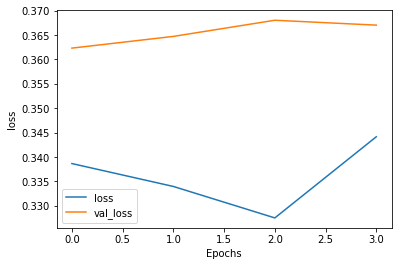

In [37]:
plot_graphs(history, 'loss')

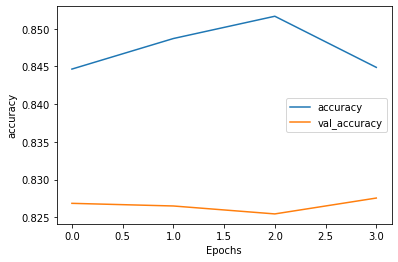

In [38]:
plot_graphs(history, 'accuracy')

### Test model

In [39]:
text = 'I dont know, this game was fun but too long'

In [40]:
predictions = model.predict(np.array([text]))
print(predictions)


[[-0.77669275]]


In [41]:
text = 'That game is just the worst, awful graphic, boring gameplay, not likeable characters'

In [42]:
predictions = model.predict(np.array([text]))
print(predictions)

[[-2.591868]]


In [43]:
text = 'I had so much fun when playing this game, keep it up devs'

In [44]:
predictions = model.predict(np.array([text]))
print(predictions)

[[0.6295048]]
